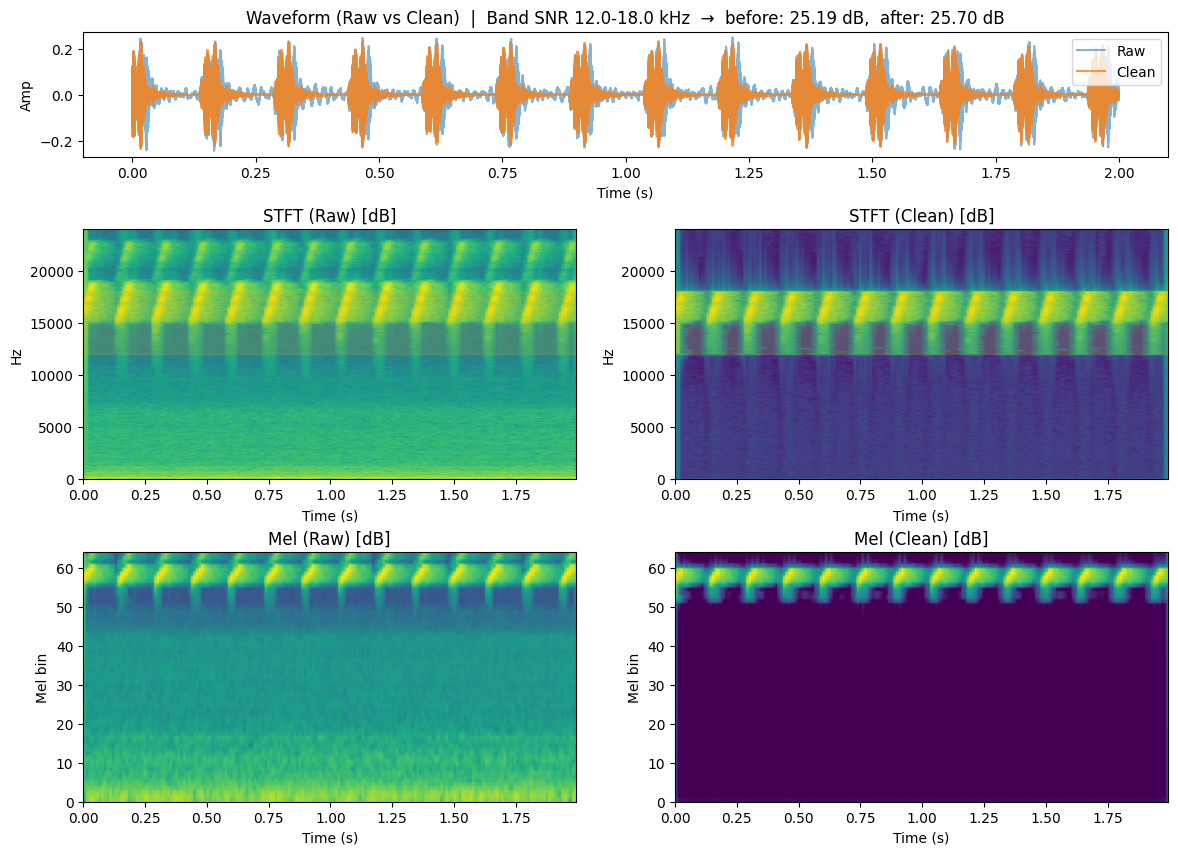

In [3]:
import numpy as np
import torch, torchaudio
import torchaudio.transforms as T
import matplotlib.pyplot as plt

# ====== CONFIG (match your training) ======
SR        = 48000
NFFT      = 2048
HOP       = 512
BAND_LO   = 12000
BAND_HI   = 18000
N_MELS    = 64

# ---------- If you already have these, you can skip redefining ----------
def _istft(S: torch.Tensor, length: int) -> torch.Tensor:
    win = torch.hann_window(NFFT, device=S.device, dtype=torch.float32)
    try:
        y = torch.istft(S, n_fft=NFFT, hop_length=HOP, win_length=NFFT,
                        window=win, length=length, center=True)
    except (TypeError, RuntimeError):
        y = torch.istft(torch.view_as_real(S), n_fft=NFFT, hop_length=HOP, win_length=NFFT,
                        window=win, length=length, center=True)
    return y

def bandpass_chunk(waveform: torch.Tensor, sr: int) -> torch.Tensor:
    # STFT-mask band-pass (no biquad/lfilter deps)
    if waveform.dim() == 1: waveform = waveform.unsqueeze(0)
    x = waveform.squeeze(0).to(torch.float32)
    S = torch.stft(x, n_fft=NFFT, hop_length=HOP, win_length=NFFT,
                   window=torch.hann_window(NFFT, dtype=torch.float32),
                   return_complex=True, center=True)
    freqs = np.fft.rfftfreq(NFFT, d=1.0/sr)
    lo = int(np.searchsorted(freqs, BAND_LO))
    hi = int(np.searchsorted(freqs, BAND_HI))
    lo = max(lo, 0); hi = min(hi, S.shape[0])
    mask = torch.zeros_like(S, dtype=torch.bool); mask[lo:hi, :] = True
    S_bp = torch.where(mask, S, torch.zeros_like(S))
    y = _istft(S_bp, length=x.numel()); y = y - y.mean()
    y = torch.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0)
    return y.unsqueeze(0)

def spectral_subtract_quiet_frames(waveform: torch.Tensor, sr: int,
                                   oversub: float = 1.2, quiet_pct: float = 0.20) -> torch.Tensor:
    x = waveform.squeeze(0); Tlen = x.numel()
    S = torch.stft(x, n_fft=NFFT, hop_length=HOP, win_length=NFFT,
                   window=torch.hann_window(NFFT, dtype=torch.float32),
                   return_complex=True, center=True)
    Mag = S.abs(); Pow = Mag**2
    freqs = np.fft.rfftfreq(NFFT, d=1.0/sr)
    lo = int(np.searchsorted(freqs, BAND_LO)); hi = int(np.searchsorted(freqs, BAND_HI))
    lo = max(lo, 0); hi = min(hi, Mag.shape[0])
    band_pow = Pow[lo:hi].mean(dim=0)  # [time]
    T_frames = band_pow.numel(); k = max(1, int(round(quiet_pct * T_frames)))
    vals, idxs = torch.topk(-band_pow, k)  # quietest frames
    quiet_mask = torch.zeros_like(band_pow, dtype=torch.bool); quiet_mask[idxs] = True
    Npsd = Pow[:, quiet_mask].mean(dim=1, keepdim=True)
    Pclean = torch.clamp(Pow - oversub * Npsd, min=0.0)
    Mag_clean = torch.sqrt(Pclean + 1e-12)
    S_clean = Mag_clean * torch.exp(1j * S.angle())
    y = _istft(S_clean, length=Tlen); y = y - y.mean()
    y = torch.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0)
    return y.unsqueeze(0)

def clean_chunk(waveform: torch.Tensor, sr: int) -> torch.Tensor:
    # mono + resample
    if waveform.dim() == 2 and waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    elif waveform.dim() == 1:
        waveform = waveform.unsqueeze(0)
    if sr != SR:
        waveform = torchaudio.functional.resample(waveform, sr, SR)
        sr = SR
    # band-pass + spectral subtraction
    y_bp = bandpass_chunk(waveform, sr)
    y_cl = spectral_subtract_quiet_frames(y_bp, sr)
    return y_cl
# ------------------------------------------------------------------------

def _stft(x):  # complex STFT
    return torch.stft(x, n_fft=NFFT, hop_length=HOP, win_length=NFFT,
                      window=torch.hann_window(NFFT, dtype=torch.float32),
                      return_complex=True, center=True)

def compute_stft_db(waveform, sr):
    x = waveform.squeeze(0)
    S = _stft(x).abs().cpu().numpy()
    Sdb = 20*np.log10(S + 1e-8)
    # axes
    freqs = np.fft.rfftfreq(NFFT, d=1.0/sr)
    times = np.arange(S.shape[1]) * (HOP / sr)
    return Sdb, freqs, times

def compute_mel_db(waveform, sr):
    mel = T.MelSpectrogram(sample_rate=sr, n_fft=1024, hop_length=512, n_mels=N_MELS)
    to_db = T.AmplitudeToDB()
    M = mel(waveform).squeeze(0)           # [n_mels, time]
    Mdb = to_db(M).cpu().numpy()
    times = np.arange(Mdb.shape[1]) * (512 / sr)
    mels  = np.arange(N_MELS)
    return Mdb, mels, times

def est_band_snr_db(waveform, sr, band=(BAND_LO, BAND_HI)):
    x = waveform.squeeze(0)
    S = _stft(x).abs()                      # [F,T]
    freqs = np.fft.rfftfreq(NFFT, 1/sr)
    lo = int(np.searchsorted(freqs, band[0])); hi = int(np.searchsorted(freqs, band[1]))
    lo = max(lo,0); hi = min(hi, S.shape[0])
    band_pow = (S[lo:hi]**2).mean(dim=0)    # [T]
    med = band_pow.median()
    Psig = band_pow[band_pow >= med].mean().item()
    Pnoi = band_pow[band_pow <  med].mean().item() + 1e-12
    return 10*np.log10(Psig / Pnoi)

def plot_preproc_compare(wav_path):
    # load
    wf, sr = torchaudio.load(wav_path)
    wf_raw = wf.clone()
    if sr != SR:
        wf_raw = torchaudio.functional.resample(wf_raw, sr, SR)
        sr = SR

    # clean
    wf_clean = clean_chunk(wf_raw, sr)

    # SNR
    snr_before = est_band_snr_db(wf_raw, sr)
    snr_after  = est_band_snr_db(wf_clean, sr)

    # STFT dB
    Sraw, fraw, traw = compute_stft_db(wf_raw, sr)
    Scln, fcln, tcln = compute_stft_db(wf_clean, sr)
    vmin = min(Sraw.min(), Scln.min())
    vmax = max(Sraw.max(), Scln.max())

    # Mel dB
    Mraw, mraw, tmraw = compute_mel_db(wf_raw, sr)
    Mcln, mcln, tmcln = compute_mel_db(wf_clean, sr)
    m_vmin = min(Mraw.min(), Mcln.min())
    m_vmax = max(Mraw.max(), Mcln.max())

    # ---------- PLOTS ----------
    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(3, 2, height_ratios=[1, 2, 2], hspace=0.35)

    # Waveforms (short view)
    ax1 = fig.add_subplot(gs[0, :])
    t = np.arange(wf_raw.shape[-1]) / sr
    ax1.plot(t, wf_raw[0].numpy(), alpha=0.55, label="Raw")
    ax1.plot(t, wf_clean[0].numpy(), alpha=0.8, label="Clean")
    ax1.set_title(f"Waveform (Raw vs Clean)  |  Band SNR {BAND_LO/1000:.1f}-{BAND_HI/1000:.1f} kHz  "
                  f"→  before: {snr_before:.2f} dB,  after: {snr_after:.2f} dB")
    ax1.set_xlabel("Time (s)"); ax1.set_ylabel("Amp"); ax1.legend(loc="upper right")

    # STFT spectrograms (dB)
    ax2 = fig.add_subplot(gs[1, 0])
    im2 = ax2.imshow(Sraw, origin="lower", aspect="auto",
                     extent=[traw[0], traw[-1], fraw[0], fraw[-1]],
                     vmin=vmin, vmax=vmax)
    ax2.set_title("STFT (Raw) [dB]"); ax2.set_xlabel("Time (s)"); ax2.set_ylabel("Hz")
    ax2.axhspan(BAND_LO, BAND_HI, color="orange", alpha=0.15)

    ax3 = fig.add_subplot(gs[1, 1])
    im3 = ax3.imshow(Scln, origin="lower", aspect="auto",
                     extent=[tcln[0], tcln[-1], fcln[0], fcln[-1]],
                     vmin=vmin, vmax=vmax)
    ax3.set_title("STFT (Clean) [dB]"); ax3.set_xlabel("Time (s)"); ax3.set_ylabel("Hz")
    ax3.axhspan(BAND_LO, BAND_HI, color="orange", alpha=0.15)

    # Mel-spectrograms (dB)
    ax4 = fig.add_subplot(gs[2, 0])
    ax4.imshow(Mraw, origin="lower", aspect="auto",
               extent=[tmraw[0], tmraw[-1], 0, N_MELS],
               vmin=m_vmin, vmax=m_vmax)
    ax4.set_title("Mel (Raw) [dB]"); ax4.set_xlabel("Time (s)"); ax4.set_ylabel("Mel bin")

    ax5 = fig.add_subplot(gs[2, 1])
    ax5.imshow(Mcln, origin="lower", aspect="auto",
               extent=[tmcln[0], tmcln[-1], 0, N_MELS],
               vmin=m_vmin, vmax=m_vmax)
    ax5.set_title("Mel (Clean) [dB]"); ax5.set_xlabel("Time (s)"); ax5.set_ylabel("Mel bin")

    plt.show()

# ---- Example:
plot_preproc_compare("recorded_audio/battery/test/full_45_seg20.wav")
# plot_preproc_compare("recorded_audio/battery/test/empty_3_seg223.wav")


